In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
# for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

#df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

# load csv
file_path = "/content/drive/My Drive/0 - School Work/Master's Classes/2025 Spring/Data Mining/NFL Play by Play 2009-2018 (v5).csv"
df = pd.read_csv(file_path)


<ipython-input-3-c24c837dcb70>:5: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [6]:
# 3) Filter to passing plays and define X/y
pass_df = df[df['play_type'] == 'pass'].dropna(subset=[
    'quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100',
    'pass_length', 'score_differential', 'qb_scramble', 'shotgun', 'no_huddle',
    'qtr', 'posteam_score', 'defteam_score', 'goal_to_go','pass_touchdown'
])

X = pass_df[[
    'quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100',
    'pass_length', 'score_differential', 'qb_scramble', 'shotgun', 'no_huddle',
    'qtr', 'posteam_score', 'defteam_score', 'goal_to_go'
]]
y = pass_df['pass_touchdown']


In [7]:
# 4) Preprocessing pipeline
categorical_cols = ['pass_length', 'qtr', 'goal_to_go']
numeric_cols     = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(),             numeric_cols),
    ('cat', OneHotEncoder(drop='first'),  categorical_cols)
])

X_proc = preprocessor.fit_transform(X)


In [8]:
# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y,
    test_size=0.20,
    random_state=513,
    stratify=y
)

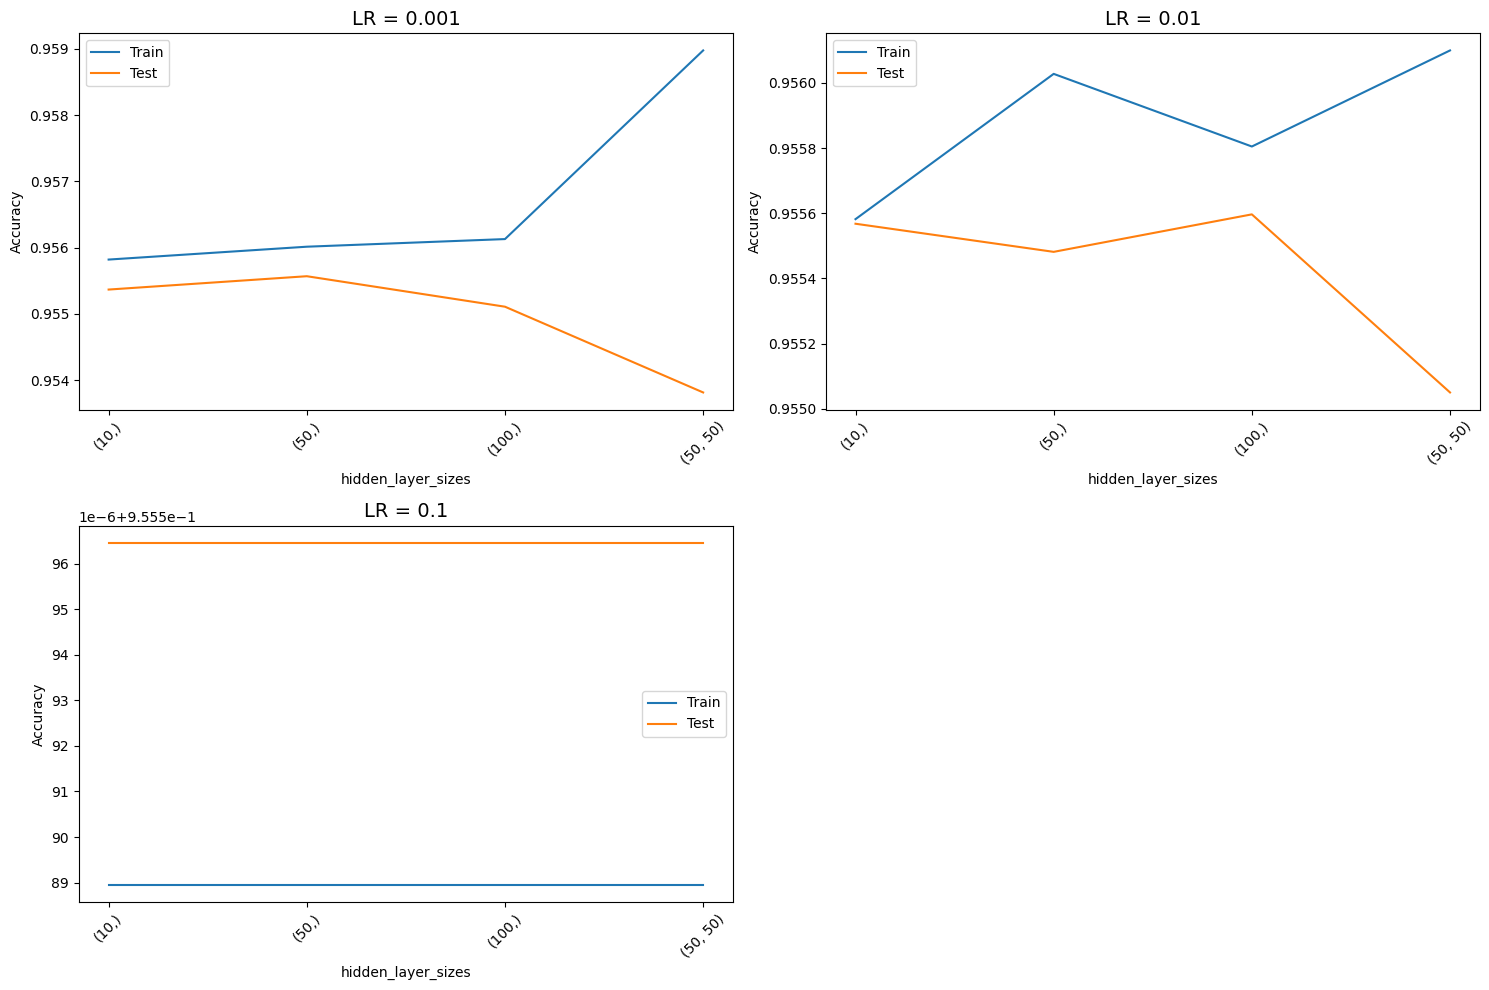

In [9]:
# 6) Hyperparameter exploration: varying hidden layer size and learning rate
hidden_sizes = [(10,), (50,), (100,), (50,50)]
lrates       = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(15, 10))
for i, lr in enumerate(lrates, 1):
    train_scores = []
    test_scores  = []
    for hs in hidden_sizes:
        mlp = MLPClassifier(hidden_layer_sizes=hs,
                            learning_rate_init=lr,
                            max_iter=200,
                            random_state=513)
        mlp.fit(X_train, y_train)
        train_scores.append(mlp.score(X_train, y_train))
        test_scores.append(mlp.score(X_test, y_test))

    ax = fig.add_subplot(2, 2, i)
    xs = range(len(hidden_sizes))
    ax.plot(xs, train_scores, label='Train')
    ax.plot(xs, test_scores,  label='Test')
    ax.set_title(f"LR = {lr}", size=14)
    ax.set_xticks(xs)
    ax.set_xticklabels([str(hs) for hs in hidden_sizes], rotation=45)
    ax.set_xlabel("hidden_layer_sizes")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [10]:
# 7) Train nn with chosen params

final_nn = MLPClassifier(
    hidden_layer_sizes=(50,50),
    learning_rate_init=0.01,
    max_iter=300,
    random_state=513
)
final_nn.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate_init=0.01,
              max_iter=300, random_state=513)

In [11]:
# 8) Evaluate
y_pred = final_nn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.95505004026228
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     33228
         1.0       0.40      0.03      0.05      1544

    accuracy                           0.96     34772
   macro avg       0.68      0.51      0.51     34772
weighted avg       0.93      0.96      0.94     34772



In [12]:
# 9) Prepare a new play with the correct feature set
new_play = pd.DataFrame({
    'quarter_seconds_remaining': [45],     # End of quarter
    'down': [1],
    'ydstogo': [1],
    'yardline_100': [1],                   # 1-yard line
    'pass_length': ['short'],
    'score_differential': [10],
    'qb_scramble': [0],
    'shotgun': [1],
    'no_huddle': [1],
    'qtr': [2],
    'posteam_score': [21],
    'defteam_score': [11],
    'goal_to_go': [True]
})


In [13]:
# 10) Transform and predict
X_new = preprocessor.transform(new_play)
prediction = final_nn.predict(X_new)[0]
probability = final_nn.predict_proba(X_new)[0][1]

print("Predicted pass touchdown (0 = No, 1 = Yes):", prediction)
print("Neural Net TD Probability:", round(probability, 4))


Predicted pass touchdown (0 = No, 1 = Yes): 0.0
Neural Net TD Probability: 0.4745
